In [ ]:
from xclib.data import data_utils
import numpy as np
import time
import pickle
import copy
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%env DATAPATH os.getcwd()+'/ass3_parta_data'

env: DATAPATH=os.getcwd()+'/ass3_parta_data'


In [19]:
%env DATAPATH

"os.getcwd()+'/ass3_parta_data'"

In [3]:
#Change this later. Make the path as command line argument
X_train = data_utils.read_sparse_file('ass3_parta_data/train_x.txt', force_header=True)
train_class = np.genfromtxt('ass3_parta_data/train_y.txt').reshape(-1, 1)

X_valid = data_utils.read_sparse_file('ass3_parta_data/valid_x.txt', force_header=True)
valid_class = np.genfromtxt('ass3_parta_data/valid_y.txt').reshape(-1, 1)

X_test = data_utils.read_sparse_file('ass3_parta_data/test_x.txt', force_header=True)
test_class = np.genfromtxt('ass3_parta_data/test_y.txt').reshape(-1, 1)

/home/ayushi/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [4]:
# Loading the number of samples and attributes
f = open('ass3_parta_data/train_x.txt') 
m,n = f.readlines()[0].rstrip("\n").split(" ")
m,n = int(m),int(n)
f.close()

In [5]:
#Determine the number of unique classes 
classes = np.unique(train_class)

In [6]:
attributes = np.array(range(X_train.A.shape[1]))

### Entropy H(Y) is calculated assuming Y only has two classes - 0 and 1

###### So we use log_2 and use pos and neg_num

In [7]:
def calc_entropyY(train_data, train_class):
    pos_num = train_data[np.where(train_class == 1)[0]].shape[0]
    neg_num = train_data[np.where(train_class == 0)[0]].shape[0]
    
    if (pos_num == 0) or (neg_num == 0):
        entr = 0 #in the limit
    else:
        entr = (pos_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/pos_num) + (neg_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/neg_num)
        
    return entr

#### Reduction in Error is given by H(Y|X) by using value to split at the node
H(Y|X) 

       = H(Y|X=x)P(X=x)  -- find the two splits 

       = H(Y=y|X=x)P(X=x) -- find the entropy of both the splits. 

       = calc_entropy(split1, train_class_split1).P(X=x)
    

In [8]:
def calc_red_error(train_data, split, split_class, train_class):
    error = 0
    for i in range(len(split)):
        error += (split[i].shape[0]/train_data.shape[0])*calc_entropyY(split[i], split_class[i])
    return error


In [9]:
def find_best_attr(train_data, train_class):
    #max_mutual_info = 0;   This doesnt work for the cases when mutual info becomes negative. 
    max_mutual_info = float("-inf");
    median = (np.median(train_data, axis=0))        
    #print(median)
    for i in range(len(attributes)):
        split = []
        split_class = []
        split.append(train_data[np.where(train_data[:,i] <= median[i])])
        split.append(train_data[np.where(train_data[:,i] > median[i])])
        split_class.append(train_class[np.where(train_data[:,i] <= median[i])])
        split_class.append(train_class[np.where(train_data[:,i] > median[i])])
        mutual_info = calc_entropyY(train_data, train_class) - calc_red_error(train_data, split, split_class, train_class)
        #print(mutual_info)
        if max_mutual_info < mutual_info:
            max_mutual_info = mutual_info
            best_attr = attributes[i]
            thres = median[i]
    return max_mutual_info, best_attr, thres

### Every Node  in the tree will have the following contents:

1. Left Subtree
2. Right Subtree
3. Attribute Name on which this node will split
4. Threshold of the attribute for left and right subtree (Median) - int value
5. Entropy
6. Whether this node is leaf or not - True/False
7. A final value of Y=0 or Y=1 in case of leaf
8. A parent

In [10]:
class newNode(object):
    def __init__(self, attr, Th, value):
        self.left = None       # Left Child
        self.right = None      # Right Child
        self.attribute = attr  # Holds the value of the attribute on which the node was split
        self.threshold = Th    # Holds the value of the threshold (Median in this case)
        self.value = value     # Holds the number of +ve and -ve samples at this node
        self.leaf = False      # Whether it is a leaf
        self.final = None      # If it is a leaf, it holds the final 0/1 prediction
        self.parent = None     # The parent node of this node
    
    def find_root(self):       # This function is used to find the root of the Tree from any point in the Tree
        while (self.parent is not None):
            self = self.parent
            self = self.find_root()
        root = self
        return root

    # To calculate Accuracy at any depth in the Tree
    def calc_accuracy(self, tra_data, tra_classes, val_data, val_classes, test_data, test_classes):
        root = self.find_root() 
        #print("Root found at = ", root)
        t_acc = 0; v_acc = 0; tes_acc = 0
        # Predicted value will be None only when a node is None (corner cases when we prune the tree)
        for i in range(len(tra_data)):
            pred = predict(root, tra_data[i])
            if (pred is None):
                continue
            if (pred == tra_classes[i]):
                t_acc+=1
        for i in range(len(val_data)):
            pred = predict(root, val_data[i])
            if (pred is None):
                continue            
            if (pred == val_classes[i]):
                v_acc += 1
        for i in range(len(test_data)):
            pred = predict(root, test_data[i])
            if (pred is None):
                continue
            if(pred == test_classes[i]):
                tes_acc+=1
        
        return t_acc/len(tra_classes), v_acc/len(val_classes), tes_acc/len(test_classes);

In [11]:
#Tree type class with build Tree function
class Tree(object):
    def __init__(self):
        self.tree = None
    def buildTree(self, data, classes, parent, depth, d_thres):
        self.tree = growTree(data, classes, parent, depth, d_thres)

In [12]:
#Prediction Function 
def predict(tree, data):
    if tree is None:
        return None
    
    # if it is leaf return final prediction
    if tree.leaf:
        return tree.final
    
    #if the tree was half-built then return the majority prediction at leaf
    if tree.left is None and tree.right is None:
        if tree.value[0] > tree.value[1]:
            return 0
        else:
            return 1
    # Traverse the tree according to the attribute
    if data[tree.attribute] <= tree.threshold:
        return predict(tree.left, data)
    elif data[tree.attribute] > tree.threshold:
        return predict(tree.right, data)


In [13]:
def growTree(train_data, classes, parent, depth, depth_threshold):
    global num_nodes #maintain the number of nodes in the tree
    pos_num = train_data[np.where(classes == 1)[0]].shape[0] #Maintain the value of +ve and -ve samples for earning stopping
    neg_num = train_data[np.where(classes == 0)[0]].shape[0]

    # If Maximum Depth reached, then make the node a leaf and assign majority prediction
    if (depth == depth_threshold):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.parent = parent
        leaf.leaf = True
        if (pos_num > neg_num):
            leaf.final = 1
        else:
            leaf.final = 0
        return leaf
            
    # else if we have reached the end of the tree i.e. when one of the class samples become 0 - make leaf
    elif(pos_num == 0 or neg_num == 0):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.leaf = True
        leaf.parent = parent
        
        # Assign final Prediction 
        if(pos_num != 0):
            leaf.final = 1
        elif(neg_num != 0):
            leaf.final = 0
        return leaf
        
    # Else Add Node according to the nest attribute to split
    else:
        mutual_info, best_attr, thresh = find_best_attr(train_data, classes)
        #print("Best Attribute with Threshold = ", best_attr, thresh)
        num_nodes+=1
        
        #Split data according to the threshold and best attribute
        left_split = train_data[np.where(train_data[:,best_attr] <= thresh)]
        right_split = train_data[np.where(train_data[:,best_attr] > thresh)]
        left_split_class = classes[np.where(train_data[:,best_attr] <= thresh)]
        right_split_class = classes[np.where(train_data[:,best_attr] > thresh)]
        
        # if all the samples went to right split, make leaf
        if (left_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.parent = parent
            
            leaf.leaf = True
            pos = left_split[np.where(left_split_class == 1)[0]].shape[0]
            neg = left_split[np.where(left_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf

        # if all the samples went to left split, make leaf
        elif (right_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.leaf = True
            leaf.parent = parent
            
            pos = right_split[np.where(right_split_class == 1)[0]].shape[0]
            neg = right_split[np.where(right_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        #Else add node and grow tree further
        else:
            addNode = newNode(best_attr, thresh, [neg_num, pos_num])
            addNode.parent = parent
            addNode.left = growTree(left_split, left_split_class, addNode, depth+1, depth_threshold)
    #print(rootT.attribute)
    #print(rootT.attribute)
            addNode.right = growTree(right_split, right_split_class, addNode, depth+1, depth_threshold)
            return addNode

In [ ]:
nodes = []
time_taken = []
train_acc=[]; val_acc= []; test_acc = []

## Set this for making the depth as a hyperparameter to the growTree function to see the accuracy
## while the tree grows. 
depth = [5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, float("inf")]

## Set this for growing Full Tree

#depth = [float("inf")]

for d in depth:
    start = time.time()
    num_nodes = 0
    root = Tree()
    print("Building Tree with depth = {}".format(d))
    root.buildTree(X_train.A, train_class, None, 0, d)
    time_taken.append(time.time() - start)
    print("Time taken to build the tree of depth {} is = {} sec".format(d, time_taken[-1]))
    with open('trees/tree_%s.csv' % d, 'wb') as f:
        pickle.dump(root,f)
    nodes.append(num_nodes)
    trainA, valA, testA = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
    train_acc.append(trainA*100)
    val_acc.append(valA*100)
    test_acc.append(testA*100)
    print("The number of nodes in Tree is = {} ".format(nodes[-1]))
    print("The Train, Val and Test Accuracy achieved on this Tree = {:2.3f}%,{:2.3f}%,{:2.3f}%".format(train_acc[-1], val_acc[-1], test_acc[-1]))
    
full_tree = copy.deepcopy(root)
#root = growTree(X_train.A, train_class, 0, 8)
#print("Time Taken to grow tree = ", time.time() - start)

Building Tree with depth = 5
Time taken to build the tree of depth 5 is = 327.5101101398468 sec
The number of nodes in Tree is = 61 
The Train, Val and Test Accuracy achieved on this Tree = 68.468%,67.852%,68.416%
Building Tree with depth = 10
Time taken to build the tree of depth 10 is = 611.5413835048676 sec
The number of nodes in Tree is = 781 
The Train, Val and Test Accuracy achieved on this Tree = 75.962%,74.476%,75.138%
Building Tree with depth = 11
Time taken to build the tree of depth 11 is = 659.9456415176392 sec
The number of nodes in Tree is = 1159 
The Train, Val and Test Accuracy achieved on this Tree = 76.611%,74.689%,75.198%
Building Tree with depth = 12
Time taken to build the tree of depth 12 is = 714.8384284973145 sec
The number of nodes in Tree is = 1625 
The Train, Val and Test Accuracy achieved on this Tree = 78.745%,76.465%,77.233%
Building Tree with depth = 13
Time taken to build the tree of depth 13 is = 766.1184735298157 sec
The number of nodes in Tree is = 21

In [ ]:
with open('params_parta.pickle', 'wb') as f:
    pickle.dump([nodes, train_acc, val_acc, test_acc], f)


In [ ]:
with open('params_parta.pickle', 'rb') as f:
    data = pickle.load(f)

nodes = data[0]
train_accuracy = data[1]
val_accuracy = data[2]
test_accuracy = data[3]

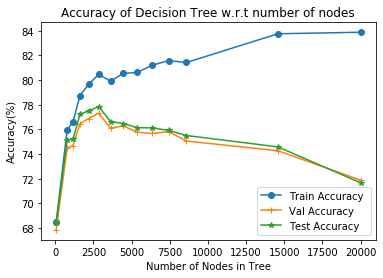

In [62]:
fig = plt.figure(1)
ax = plt.add_subplot(111)

ax.plot(nodes, train_acc, marker='o', label='Train Accuracy ')
ax.plot(nodes, val_acc, marker='+', label='Val Accuracy')
ax.plot(nodes, test_acc, marker='*', label='Test Accuracy')
ax.set_xlabel("Number of Nodes in Tree")
ax.set_ylabel("Accuracy(%)")
ax.set_title("Accuracy of Decision Tree w.r.t number of nodes")
ax.legend()
#ax.savefig("plots/depth_accuracy_final.png", dpi=1000, bbox_inches='tight')
plt.show()

In [15]:
with open('trees/tree_inf.pickle', 'rb') as f:
    root = pickle.load(f)

In [16]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [ ]:
def printPreorder(graph): 
    global n
    if graph: 
        n+=1     #To Count the number of nodes 
  
        #print(graph, graph.attribute, graph.leaf, graph.parent, graph.final), 
        print(graph.attribute, end=' ')
        
        printPreorder(graph.left)

        printPreorder(graph.right) 
  

In [18]:
print("--------------Original Full-Grown Tree Accuracy------------------------------\n")
print("Number of Nodes = ", n)
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Original Tree------------------------------

Number of Nodes =  482
The Training Accuracy on Full-Grown Tree is = 83.875%
The Vaidation Accuracy on Full-Grown Tree is = 71.885%
The Test Accuracy on Full-Grown Tree is = 71.675%


# Post Pruning the tree by traversing in PreOrder -> root-left-right


In [76]:
with open('trees/tree_inf.pickle', 'rb') as f:
    root = pickle.load(f)

In [78]:
def PreOrderPrune(rootT): 
    global prune_num # Maintain the number of nodes that are pruned in a given iteration
    
    # If it is a leaf, return as it is
    if rootT.attribute is None:
        return rootT
      
    if rootT is None:
        return None
    
    # Else find Nodes to prune one by one
    if rootT.left.leaf == True and rootT.right.leaf == True:
        prune_num+=1
        new_root = rootT
        new_root.leaf = True
        # Make these nodes Leaf and assign final prediction as majority prediction
        new_root.final = [1 if rootT.value[0]<rootT.value[1] else 0][0]
        temp = rootT
        rootT = None
        del(temp)
        return new_root

    rootT.left = PreOrderPrune(rootT.left) 
        
    rootT.right = PreOrderPrune(rootT.right)

    return rootT

In [79]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
train_acc_prune_leaf = [train_acc]
val_acc_prune_leaf = [val_acc]
test_acc_prune_leaf = [test_acc]
pruned_nodes = [0]

#Prune the Tree till the depth that started giving overfitting in the original full-grown tree
for i in range(depth[-3]):
    prune_num=0
    PreOrderPrune(root.tree)
    pruned_nodes.append(prune_num)
    train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)    
    if(val_acc > val_acc_prune_leaf[-1]):
        optimal_idx = i+1 # Store the optimal index of the tree which has the highest Val Accuracy
        newG = copy.deepcopy(root.tree) # Store the deep copy of that tree
    train_acc_prune_leaf.append(np.round(train_acc*100, 3))
    val_acc_prune_leaf.append(np.round(val_acc*100, 3)
    test_acc_prune_leaf.append(np.round(test_acc*100, 3))

train_acc_prune_leaf = [np.round(x*100,2) for x in train_acc_prune_leaf]
val_acc_prune_leaf = [np.round(x*100,2) for x in val_acc_prune_leaf]
test_acc_prune_leaf = [np.round(x*100,2) for x in test_acc_prune_leaf]

In [81]:
pruned_total = [sum(pruned_nodes[:x]) for x in range(1, len(pruned_nodes) + 1)]
nodes_left = [n-x for x in pruned_total]
#print(nodes_left)

[19999, 17457, 15010, 12890, 11134, 9712, 8550, 7599, 6821, 6172, 5620, 5151, 4749, 4394, 4091, 3829, 3593, 3389, 3212, 3059, 2920]


In [82]:
train_acc, val_acc, test_acc = newG.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [83]:
print("--------------Optimal Tree after Post-Pruning PreOrder Traversal------------------------------\n")
print("Number of Nodes in Pruned Tree = ", nodes_left[optimal_idx])
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Optimal Tree after Iterative Pruning------------------------------

Number of Nodes =  6821
The Training Accuracy on Full-Grown Tree is = 81.501%
The Vaidation Accuracy on Full-Grown Tree is = 79.038%
The Test Accuracy on Full-Grown Tree is = 79.064%


print("The Training Accuracy are = ", train_acc_prune_leaf)
print("The Validation Accuracy are = ", val_acc_prune_leaf)
print("The Test Accuracy are = ", test_acc_prune_leaf)

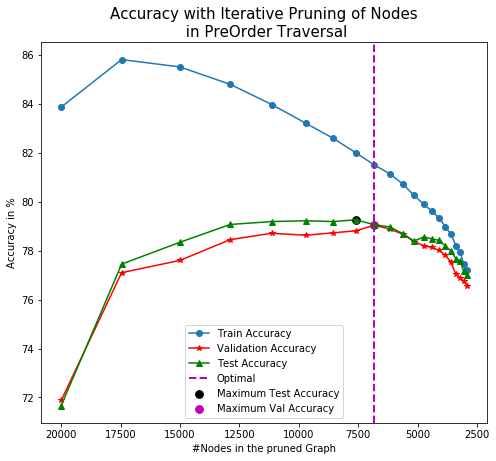

In [85]:
x = [i for i in range(16)]

fig = plt.figure(figsize=(8,7))
ax1=fig.add_subplot(111)

ax1.plot(nodes_left, train_acc_prune_leaf, marker='o', label='Train Accuracy')
ax1.plot(nodes_left, val_acc_prune_leaf, marker='*', c='r', label='Validation Accuracy')
ax1.plot(nodes_left, test_acc_prune_leaf, marker='^', c='g', label='Test Accuracy')
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.axvline(x=nodes_left[optimal_idx], c='m',linestyle='--', linewidth=2, label='Optimal')
ax1.scatter(nodes_left[optimal_idx-1], test_acc_prune_leaf[optimal_idx-1], c='k', marker='o',s=60, label='Maximum Test Accuracy')
ax1.scatter(nodes_left[optimal_idx], val_acc_prune_leaf[optimal_idx], c='m', marker='o',s=60, label='Maximum Val Accuracy')
ax1.set_xlabel("#Nodes in the pruned Graph")
ax1.set_ylabel("Accuracy in %")
ax1.set_title("Accuracy with Iterative Pruning of Nodes\n in PreOrder Traversal", fontsize=15)
ax1.legend()
#plt.savefig("plots/IterativeLeafPruningPreOrder.png", dpi=1000, bbox_inches='tight')

plt.show()


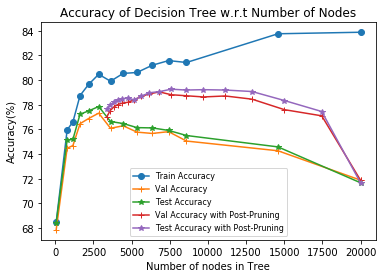

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nodes, train_accuracy, marker='o', label='Train Accuracy ')
plt.plot(nodes, val_accuracy, marker='+', label='Val Accuracy')
plt.plot(nodes, test_accuracy, marker='*', label='Test Accuracy')

#plt.plot(prune, train_prune, marker='o', c='y', label='Train Accuracy ')
plt.plot(prune, val_prune, marker='+', label='Val Accuracy with Post-Pruning')
plt.plot(prune, test_prune, marker='*', label='Test Accuracy with Post-Pruning')
plt.xlabel("Number of nodes in Tree")
plt.ylabel("Accuracy(%)")
plt.title("Accuracy of Decision Tree w.r.t Number of Nodes")

#plt.plot(prune, depth)
plt.legend(fontsize=8)
#plt.savefig("plots/depth_accuracy_withPrune.png", dpi=1000, bbox_inches='tight')
plt.show()

# Post Pruning in different traversal order - Inorder -> Left-Root-Right

In [86]:
with open('trees/tree_inf.pickle', 'rb') as f:
    root = pickle.load(f)

In [87]:
def InOrderPrune(rootT): 
    global prune_num
        
    if rootT.attribute is None:
        return rootT
      
    if rootT is None:
        return None
    
    rootT.left = InOrderPrune(rootT.left) 
    
    if rootT.left.leaf == True and rootT.right.leaf == True:
        prune_num+=1
        new_root = rootT
        new_root.leaf = True
        new_root.final = [1 if rootT.value[0]<rootT.value[1] else 0][0]
        temp = rootT
        rootT = None
        del(temp)

        return new_root
        
    rootT.right = InOrderPrune(rootT.right)

    return rootT

In [88]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
train_acc_prune_leaf = [train_acc]
val_acc_prune_leaf = [val_acc]
test_acc_prune_leaf = [test_acc]
pruned_nodes = [0]
for i in range(depth[-3]):
    prune_num=0
    InOrderPrune(root.tree)
    pruned_nodes.append(prune_num)
    train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)    
    if(val_acc > val_acc_prune_leaf[-1]):
        optimal_idx = i+1
        newG = copy.deepcopy(root.tree)
    train_acc_prune_leaf.append(train_acc)
    val_acc_prune_leaf.append(val_acc)
    test_acc_prune_leaf.append(test_acc)

In [89]:
train_acc_prune_leaf = [np.round(x*100,2) for x in train_acc_prune_leaf]
val_acc_prune_leaf = [np.round(x*100,2) for x in val_acc_prune_leaf]
test_acc_prune_leaf = [np.round(x*100,2) for x in test_acc_prune_leaf]

In [90]:
pruned_total = [sum(pruned_nodes[:x]) for x in range(1, len(pruned_nodes) + 1)]

nodes_left = [n-x for x in pruned_total]
#print(nodes_left)

[19999, 15624, 11261, 7561, 4887, 3126, 2142, 1499, 1089, 898, 771, 745, 719, 693, 667, 641]


In [91]:
train_acc, val_acc, test_acc = newG.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [92]:
print("--------------Optimal Tree after Iterative Pruning in Inorder way------------------------------\n")
print("Number of Nodes left in Pruned Tree = ", nodes_left[optimal_idx])
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Optimal Tree after Iterative Pruning------------------------------

Number of Nodes =  7561
The Training Accuracy on Full-Grown Tree is = 81.481%
The Vaidation Accuracy on Full-Grown Tree is = 78.500%
The Test Accuracy on Full-Grown Tree is = 79.027%


print("The Training Accuracy are = ", train_acc_prune_leaf)
print("The Validation Accuracy are = ", val_acc_prune_leaf)
print("The Test Accuracy are = ", test_acc_prune_leaf)

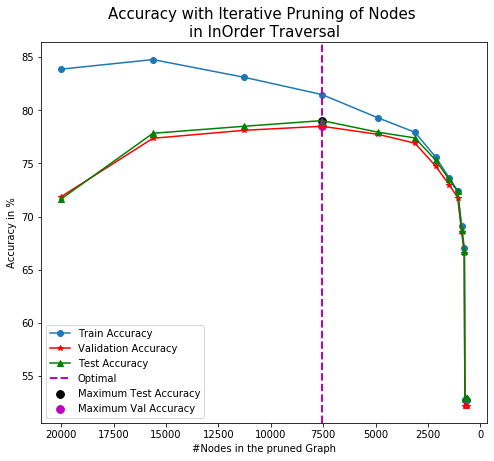

In [94]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,7))
ax1=fig.add_subplot(111)

ax1.plot(nodes_left, train_acc_prune_leaf, marker='o', label='Train Accuracy')
ax1.plot(nodes_left, val_acc_prune_leaf, marker='*', c='r', label='Validation Accuracy')
ax1.plot(nodes_left, test_acc_prune_leaf, marker='^', c='g', label='Test Accuracy')
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.axvline(x=nodes_left[optimal_idx], c='m',linestyle='--', linewidth=2, label='Optimal')
ax1.scatter(nodes_left[optimal_idx], test_acc_prune_leaf[optimal_idx], c='k', marker='o',s=60, label='Maximum Test Accuracy')
ax1.scatter(nodes_left[optimal_idx], val_acc_prune_leaf[optimal_idx], c='m', marker='o',s=60, label='Maximum Val Accuracy')
ax1.set_xlabel("#Nodes in the pruned Graph")
ax1.set_ylabel("Accuracy in %")
ax1.set_title("Accuracy with Iterative Pruning of Nodes \nin InOrder Traversal", fontsize=15)
ax1.legend()

#plt.savefig("plots/IterativeLeafPruningInOrder.png", dpi=1000, bbox_inches='tight')

plt.show()
